****Google Play Store apps and reviews****

Mobile apps are everywhere. They are easy to create and can be lucrative. Because of these two factors, more and more apps are being developed. In this notebook, we will do a comprehensive analysis of the Android app market by comparing over ten thousand apps in Google Play across different categories. We'll look for insights in the data to devise strategies to drive growth and retention.

****Data****

apps.csv: contains all the details of the applications on Google Play. There are 13 features that describe a given app.
    
user_reviews.csv: contains 100 reviews for each app, most helpful first. The text in each review has been pre-processed and attributed with three new features: Sentiment (Positive, Negative or Neutral), Sentiment Polarity and Sentiment Subjectivity.

In [2]:
#importing libraries
import pandas as pd
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Loading the Datasets
apps_with_duplicates = pd.read_csv("datasets/apps.csv")

# Drop duplicates from apps_with_duplicates
apps = apps_with_duplicates.drop_duplicates()

# Print the total number of apps
print('Total number of apps in the dataset = ',len(apps))
print('\n')
# Print a summary of apps dataframe
print(apps.info())
print('\n')
# Have a look at a random sample of 5 rows
print(apps.head())

Total number of apps in the dataset =  9659


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9659 entries, 0 to 9658
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      9659 non-null   int64  
 1   App             9659 non-null   object 
 2   Category        9659 non-null   object 
 3   Rating          8196 non-null   float64
 4   Reviews         9659 non-null   int64  
 5   Size            8432 non-null   float64
 6   Installs        9659 non-null   object 
 7   Type            9659 non-null   object 
 8   Price           9659 non-null   object 
 9   Content Rating  9659 non-null   object 
 10  Genres          9659 non-null   object 
 11  Last Updated    9659 non-null   object 
 12  Current Ver     9651 non-null   object 
 13  Android Ver     9657 non-null   object 
dtypes: float64(2), int64(2), object(10)
memory usage: 1.1+ MB
None


   Unnamed: 0                                            

****Data Cleaning****

The four features that we will be working with most frequently henceforth are Installs, Size, Rating and Price. The info() function tells us that Installs and Price columns are of type object and not int or float as we would expect. This is because the column contains some characters more than just [0,9] digits. Ideally, we would want these columns to be purely numeric as their name suggests.

Hence, we now need to clean our data. Specifically, the special characters , and + present in Installs column and $ present in Price column needs to be removed.

In [4]:
# List of characters to remove
chars_to_remove = ["+",",","$"]
# List of column names to clean
cols_to_clean = ["Installs","Price"]

# Loop for each column in cols_to_clean
for col in cols_to_clean:
    # Loop for each char in chars_to_remove
    for char in chars_to_remove:
        # Replace the character with an empty string
        apps[col] = apps[col].apply(lambda x: x.replace(char,''))
    # Convert col to float data type
    apps[col] = apps[col].astype(float)       

****Exploring Categories****

In [5]:
# Print the total number of unique categories
num_categories = apps['Category'].nunique()
print('Number of categories = ', num_categories)

# Count the number of apps in each 'Category'. Sort in descending order depending on number of apps in each category
num_apps_in_category = apps["Category"].value_counts().sort_values(ascending=False)

data = [go.Bar(
        x = num_apps_in_category.index, # index = category name
        y = num_apps_in_category.values, # value = count
)]
plotly.offline.iplot(data)

Number of categories =  33


****Distribution of app ratings****

After having witnessed the market share for each category of apps, let's see how all these apps perform on an average. App ratings (on a scale of 1 to 5) impact the discoverability, conversion of apps as well as the company's overall brand image. Ratings are a key performance indicator of an app.

In [6]:
# Average rating of apps
avg_app_rating = apps["Rating"].mean()
print('Average app rating = ', avg_app_rating)

# Distribution of apps according to their ratings
data = [go.Histogram(
        x = apps['Rating']
)]

# Vertical dashed line to indicate the average app rating
layout = {'shapes': [{
              'type' :'line',
              'x0': avg_app_rating,
              'y0': 0,
              'x1': avg_app_rating,
              'y1': 1000,
              'line': { 'dash': 'dashdot'}
          }]
          }

plotly.offline.iplot({'data': data, 'layout': layout})

Average app rating =  4.173243045387998


****Size and price of app****

For size, if the mobile app is too large, it may be difficult and/or expensive for users to download. Lengthy download times could turn users off before they even experience your mobile app. Plus, each user's device has a finite amount of disk space. For price, some users expect their apps to be free or inexpensive. These problems compound if the developing world is part of your target market; especially due to internet speeds, earning power and exchange rates.

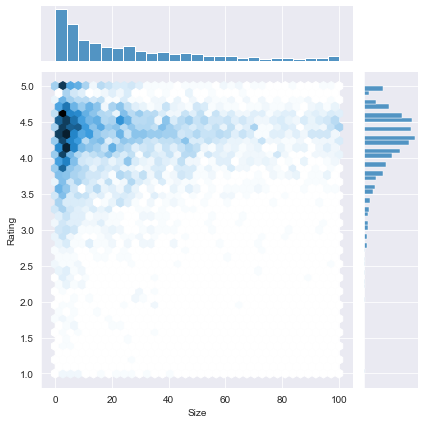

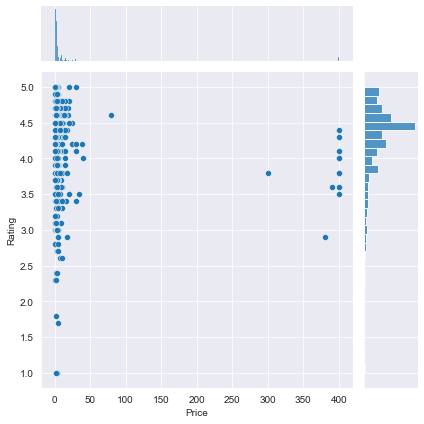

In [7]:
# Select rows where both 'Rating' and 'Size' values are present (ie. the two values are not null)
apps_with_size_and_rating_present = apps[(~apps["Rating"].isnull())&(~apps["Size"].isnull())]

# Subset for categories with at least 250 apps
large_categories = apps_with_size_and_rating_present.groupby("Category").filter(lambda x: len(x) >= 250)

# Plot size vs. rating
plt1 = sns.jointplot(x = large_categories["Size"], y = large_categories["Rating"],kind='hex')

# Select apps whose 'Type' is 'Paid'
paid_apps = apps_with_size_and_rating_present[apps["Type"]=="Paid"]

# Plot price vs. rating
plt2 = sns.jointplot(x = paid_apps["Price"], y = paid_apps["Rating"],data=paid_apps)

****Relation between category and price****

,Category,App,Price
3327,FAMILY,most expensive app (H),399.99
3465,LIFESTYLE,💎 I'm rich,399.99
3469,LIFESTYLE,I'm Rich - Trump Edition,400.00
4396,LIFESTYLE,I am rich,399.99
4398,FAMILY,I am Rich Plus,399.99
4399,LIFESTYLE,I am rich VIP,299.99
4400,FINANCE,I Am Rich Premium,399.99
4401,LIFESTYLE,I am extremely Rich,379.99
4402,FINANCE,I am Rich!,399.99
4403,FINANCE,I am rich(premium),399.99


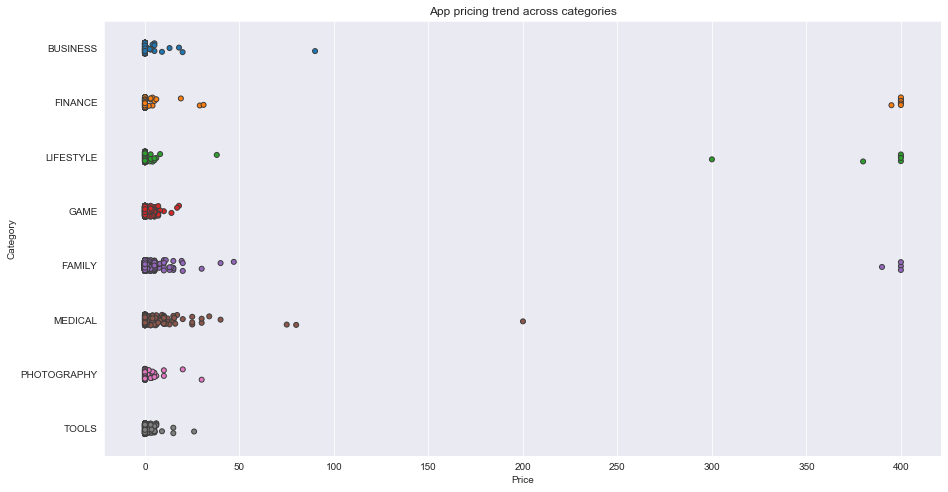

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)

# Select a few popular app categories
popular_app_cats = apps[apps.Category.isin(['GAME', 'FAMILY', 'PHOTOGRAPHY',
                                            'MEDICAL', 'TOOLS', 'FINANCE',
                                            'LIFESTYLE','BUSINESS'])]

# Examine the price trend by plotting Price vs Category
ax = sns.stripplot(x = popular_app_cats["Price"], y = popular_app_cats["Category"], jitter=True, linewidth=1)
ax.set_title('App pricing trend across categories')

# Apps whose Price is greater than 200

apps_above_200 = apps[['Category', 'App', 'Price']].loc[apps["Price"]>200]
apps_above_200

Filtering out junk apps

Text(0.5, 1.0, 'App pricing trend across categories after filtering for junk apps')

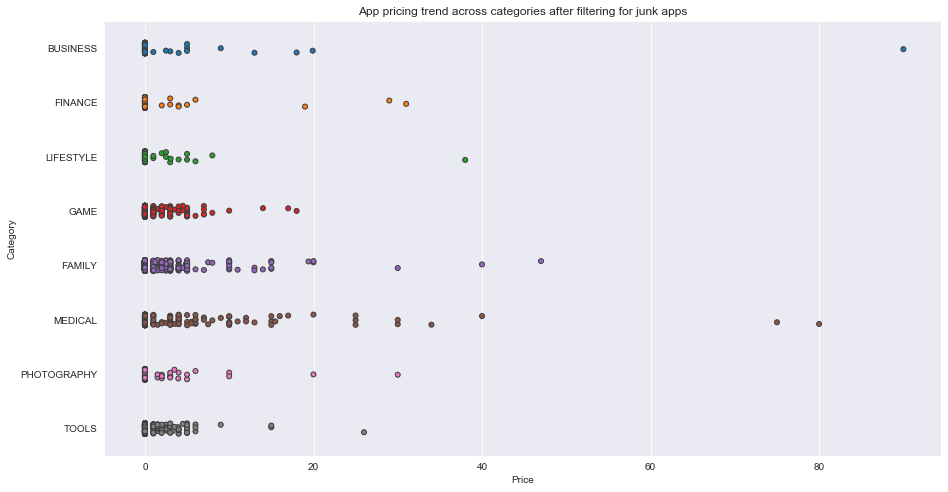

In [9]:
# Select apps priced below $100
apps_under_100 = popular_app_cats.loc[popular_app_cats["Price"]<100]

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)

# Examine price vs category with the authentic apps (apps_under_100)
ax = sns.stripplot(x = "Price", y = "Category", data = apps_under_100, jitter = True, linewidth = 1)
ax.set_title('App pricing trend across categories after filtering for junk apps')

Paid vs free apps

In [10]:
trace0 = go.Box(
    # Data for paid apps
    y = apps[apps['Type'] == "Paid"]['Installs'],
    name = 'Paid'
)

trace1 = go.Box(
    # Data for free apps
    y = apps[apps['Type'] == "Free"]['Installs'],
    name = 'Free'
)

layout = go.Layout(
    title = "Number of downloads of paid apps vs. free apps",
    yaxis = dict(title = "Log number of downloads",
                type = 'log',
                autorange = True)
)

# Add trace0 and trace1 to a list for plotting
data = [trace0, trace1]
plotly.offline.iplot({'data': data, 'layout': layout})

Sentiment analysis of user reviews

Text(0.5, 1.0, 'Sentiment Polarity Distribution')

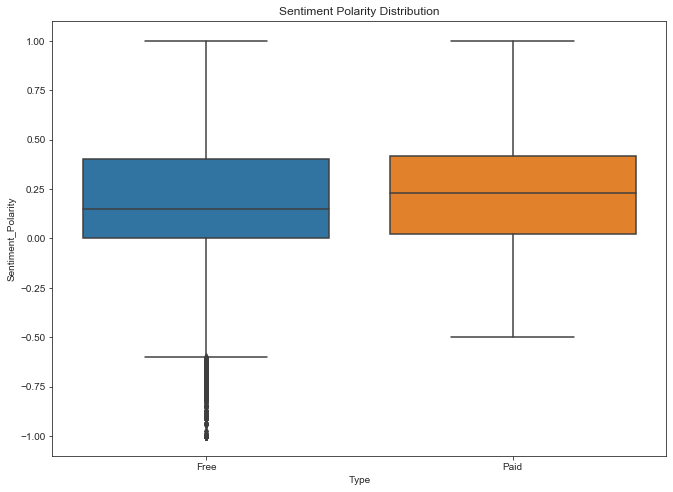

In [12]:
# Load user_reviews.csv
reviews_df = pd.read_csv('datasets/user_reviews.csv')

# Join the two dataframes
merged_df = pd.merge(apps,reviews_df,on="App",how='inner')

# Drop NA values from Sentiment and Review columns
merged_df = merged_df.dropna(subset = ['Sentiment', 'Review'])

sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)

# User review sentiment polarity for paid vs. free apps
ax = sns.boxplot(x = "Type", y = "Sentiment_Polarity", data = merged_df)
ax.set_title('Sentiment Polarity Distribution')